# Cavern storage capacity (feasible)

height > 85 m, depth of 500-2,000 m, and free gas volumes of at least 380,000 m³

In [119]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns
from h2ss import compare

In [16]:
import importlib

In [65]:
importlib.reload(fns)

<module 'h2ss.functions' from '/run/media/nms/Backup/Documents/Git/wind-to-hydrogen-toolkit/hydrogen-salt-storage/h2ss/functions.py'>

In [91]:
importlib.reload(compare)

<module 'h2ss.compare' from '/run/media/nms/Backup/Documents/Git/wind-to-hydrogen-toolkit/hydrogen-salt-storage/h2ss/compare.py'>

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [67]:
CAVERN_DIAMETER = 85
SEPARATION = 4 * CAVERN_DIAMETER
PILLAR_WIDTH = 3 * CAVERN_DIAMETER

## Halite data

In [4]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

In [68]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds, buffer=PILLAR_WIDTH)

## Zones of interest

In [70]:
# net height >= 85 m, 500 m <= depth <= 2,000 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"net_height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [71]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
    diameter=CAVERN_DIAMETER,
    separation=SEPARATION,
)

In [72]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [73]:
# label caverns by depth, use dynamic height
caverns = fns.label_caverns(
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [74]:
caverns.drop(columns=["x", "y", "BaseDepth", "TopDepth", "TopTWT", "BaseDepthSeabed"]).describe()

,y,x,BaseDepth,Thickness,TopDepth,TopTWT,TopDepthSeabed,BaseDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_height,cavern_depth
count,9.790000e+02,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,5.915964e+06,711270.275792,1374.037786,406.754248,967.283537,714.081293,923.306596,1330.060845,-43.976936,0.628970,260.665188,316.754248,1003.306596
std,9.679473e+03,7694.576545,392.130166,91.522062,381.402366,206.203904,378.657543,388.315413,17.050642,0.058126,86.413800,91.522062,378.657543
min,5.894200e+06,697800.000000,790.960600,316.667500,438.429300,390.241100,420.794808,752.279771,-80.510788,0.554650,175.639663,226.667500,500.794808
25%,5.906200e+06,704100.000000,1059.329850,347.171600,649.805350,567.345000,613.336098,1022.355129,-58.691734,0.582872,202.356524,257.171600,693.336098
50%,5.919400e+06,710200.000000,1319.938600,378.011000,905.685300,675.484000,861.484152,1272.699274,-42.494362,0.611404,231.117300,288.011000,941.484152
75%,5.923700e+06,718200.000000,1638.554450,430.614750,1215.107050,817.258400,1151.855822,1587.786909,-27.676800,0.660071,284.236466,340.614750,1231.855822
max,5.929200e+06,728800.000000,2647.050800,992.179400,1960.665400,1350.132800,1909.717677,2602.594173,-5.811832,0.750000,744.134550,902.179400,1989.717677


In [75]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 979
------------------------------------------------------------
Excluding salt formation edges...
Number of potential caverns: 945
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 470
Caverns excluded: 50.26%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------


## Capacity

### Cavern volume

In [76]:
caverns["cavern_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"], diameter=CAVERN_DIAMETER
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"], f_if=(1 - caverns["NetToGross"])
)

### Mid-point temperature

In [77]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [78]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

### Hydrogen gas density

In [79]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [80]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [81]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [82]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [84]:
caverns.drop(columns=["x", "y", "BaseDepth", "TopDepth", "TopTWT", "BaseDepthSeabed"]).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,3.990000e+02,399.000000,3.990000e+02,3.990000e+02,399.000000,399.000000,3.990000e+02,3.990000e+02,3.990000e+02,399.000000,399.000000
mean,392.692637,1053.269888,-47.942230,0.621016,247.034600,302.692637,1133.269888,6.000464e+05,331.323108,7.763186e+06,2.070183e+07,5.357794,13.280239,4.805327e+06,3.251091e+06,8.056418e+06,160.124177,0.598746
std,69.115380,379.820048,13.520585,0.049226,66.379385,69.115380,379.820048,2.350655e+05,14.425774,2.682745e+06,7.153987e+06,1.559241,3.610226,2.296452e+06,1.602927e+06,3.897765e+06,76.522874,0.008068
min,316.764900,421.304826,-76.084564,0.554740,175.722230,226.764900,501.304826,3.583818e+05,306.560650,3.299490e+06,8.798641e+06,2.558089,6.610497,1.513184e+06,9.569612e+05,2.470241e+06,50.422644,0.581979
25%,347.146400,735.556125,-60.474541,0.582848,202.333742,257.146400,815.556125,4.445514e+05,319.107134,5.519110e+06,1.471763e+07,4.072302,10.320989,3.115426e+06,2.037612e+06,5.151465e+06,103.812909,0.592840
50%,375.021400,1030.925564,-43.752434,0.608638,228.252174,285.021400,1110.925564,5.311486e+05,330.418494,7.605363e+06,2.028097e+07,5.347250,13.330064,4.246456e+06,2.818929e+06,7.060609e+06,141.501354,0.598858
75%,417.471050,1318.617475,-41.456015,0.647911,270.484140,327.471050,1398.617475,6.768785e+05,341.682183,9.637389e+06,2.569970e+07,6.499186,15.962231,6.160347e+06,4.228138e+06,1.032121e+07,205.276436,0.605440
max,822.710300,1900.680682,-18.320551,0.750000,617.032725,732.710300,1980.680682,1.935479e+06,362.584018,1.374862e+07,3.666298e+07,8.578741,20.522248,1.548059e+07,1.037756e+07,2.585816e+07,515.847731,0.613026


In [89]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         2.394185e+08
working_mass          1.917326e+09
capacity              6.388955e+04
mass_operating_min    1.297185e+09
mass_operating_max    3.214511e+09
dtype: float64

In [92]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
compare.electricity_demand_ie(caverns_df=caverns)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 52.37–76.06%


In [100]:
# total capacity at various depth/height combinations
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,32060.982101,50.181890
"500 - 1,000",Rossall,9544.735029,14.939431
"1,500 - 2,000",Rossall,10587.921720,16.572229
"1,000 - 1,500",Preesall,264.477898,0.413961
"500 - 1,000",Preesall,3673.868635,5.750344
"1,500 - 2,000",Preesall,2310.311176,3.616102
"1,000 - 1,500",Fylde,1855.337330,2.903976
"1,500 - 2,000",Fylde,982.058135,1.537119
"500 - 1,000",Fylde,2609.854436,4.084948


In [102]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",34180.797330
"1,500 - 2,000",13880.291031
"500 - 1,000",15828.458100


In [103]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,5447.249901
Preesall,6248.657710
Rossall,52193.638850


In [104]:
# number of caverns
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,172,43.107769
"500 - 1,000",Rossall,82,20.551378
"1,500 - 2,000",Rossall,46,11.528822
"1,000 - 1,500",Preesall,2,0.501253
"500 - 1,000",Preesall,37,9.273183
"1,500 - 2,000",Preesall,14,3.508772
"1,000 - 1,500",Fylde,13,3.258145
"1,500 - 2,000",Fylde,5,1.253133
"500 - 1,000",Fylde,28,7.017544


In [105]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",187
"1,500 - 2,000",65
"500 - 1,000",147


In [107]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,46
Preesall,53
Rossall,300


In [108]:
# copy dataframe
caverns_pot_all = caverns.copy()

## Map

In [109]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [130]:
def plot_map_alt(
    dat_xr, cavern_df, zones_gdf, classes, quantity="capacity", quantity_label="Hydrogen storage \ncapacity [GWh]", top_depth=True, fontsize=11.5
):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis1 = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles1 = []
    classes = sorted(classes)

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis1,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis1, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis1,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis1,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles1.append(mpatches.Patch(label=quantity_label, visible=False))

    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    for n, y in enumerate(colours):
        if n == 0:
            c = cavern_df[cavern_df[quantity] < classes[1]]
            label1 = f"< {classes[1]}"
        elif n == len(classes) - 1:
            c = cavern_df[cavern_df[quantity] >= classes[n]]
            label1 = f"≥ {classes[n]}"
        else:
            c = cavern_df[
                (cavern_df[quantity] >= classes[n])
                & (cavern_df[quantity] < classes[n + 1])
            ]
            label1 = f"{classes[n]}–{classes[n + 1]}"
        if top_depth:
            for df, markersize in zip(
                [
                    c[c["depth"] == "500 - 1,000"],
                    c[c["depth"] == "1,000 - 1,500"],
                    c[c["depth"] == "1,500 - 2,000"],
                ],
                [20, 50, 20],
            ):
                if len(df) > 0:
                    df.centroid.plot(
                        ax=axis1,
                        zorder=3,
                        linewidth=0,
                        marker=".",
                        markersize=markersize,
                        color=sns.color_palette("flare", 256)[y],
                    )
        else:
            gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
                ax=axis1,
                scheme="UserDefined",
                classification_kwds={"bins": classes[1:]},
                column=quantity,
                zorder=3,
                marker=".",
                cmap="flare",
                markersize=20,
            )
        legend_handles1.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=label1
            )
        )

    if top_depth:
        legend_handles1.append(
            mpatches.Patch(label="Cavern top depth [m]", visible=False)
        )
        for markersize, label1 in zip(
            [6, 3], ["1,000–1,500", "500–1,000 or \n1,500–2,000"]
        ):
            legend_handles1.append(
                Line2D(
                    [0],
                    [0],
                    marker=".",
                    linewidth=0,
                    label=label1,
                    color="darkslategrey",
                    markersize=markersize,
                )
            )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis1, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=12
    )
    axis1.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
    )
    axis1.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles1,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

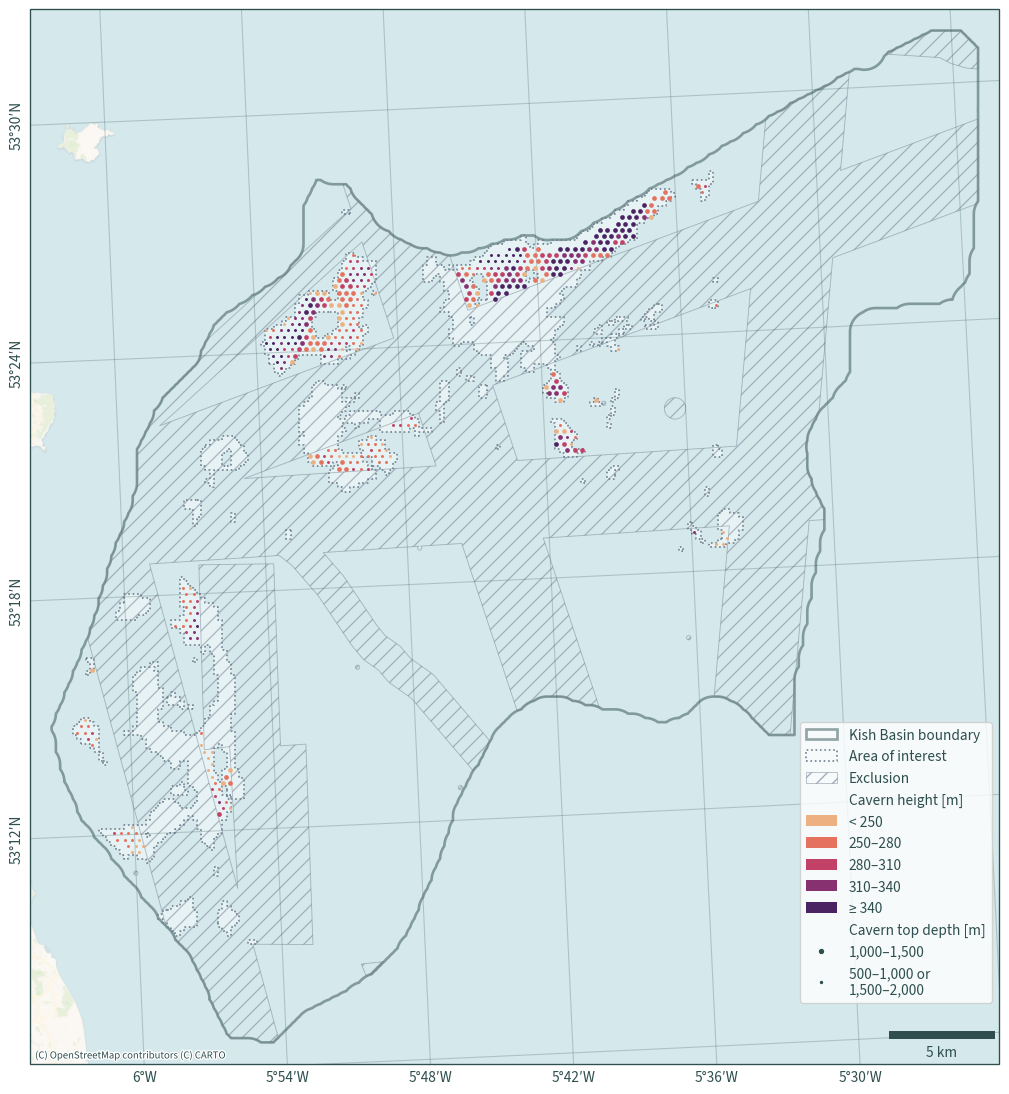

In [137]:
plot_map_alt(ds, caverns, zones, [0, 250, 280, 310, 340], quantity="cavern_height", quantity_label="Cavern height [m]")

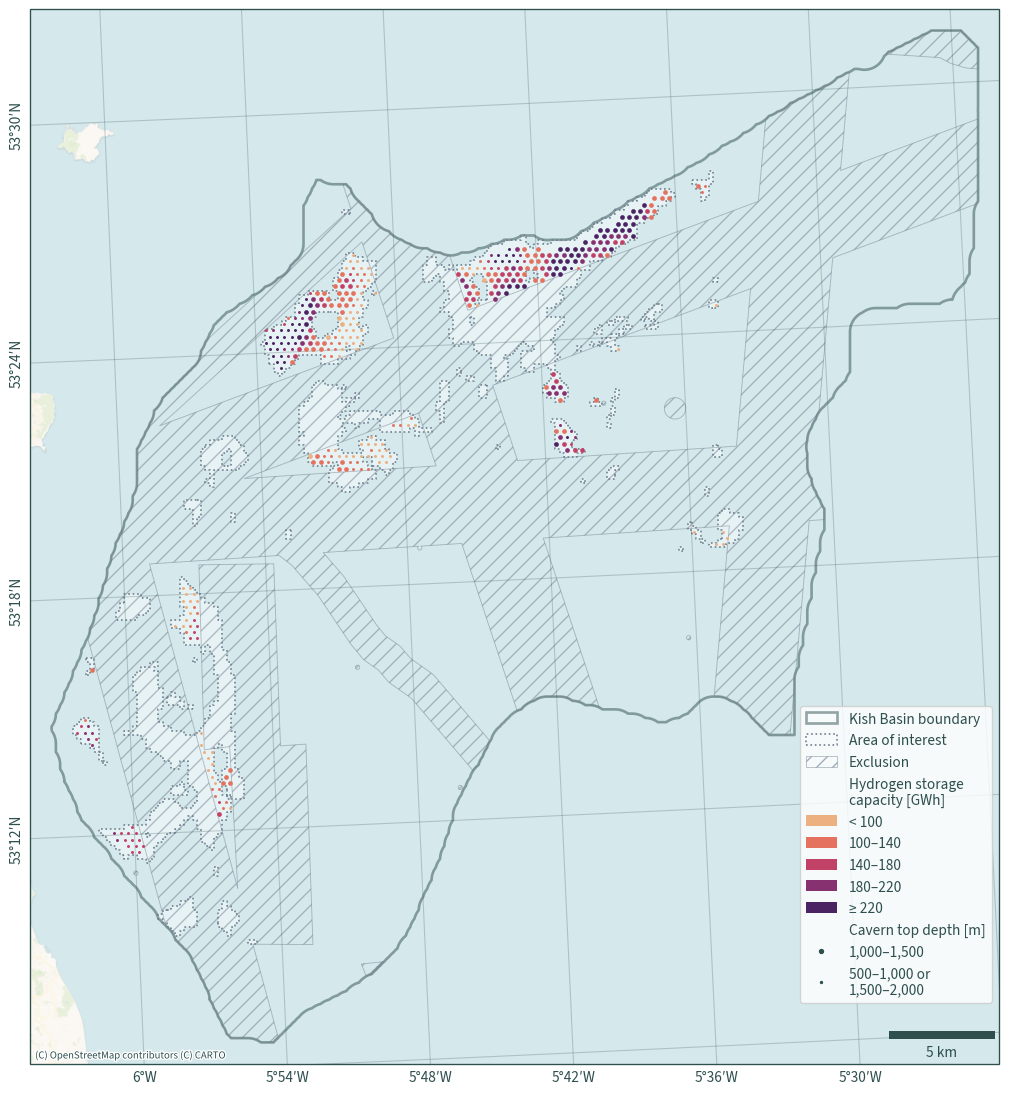

In [138]:
plot_map_alt(ds, caverns, zones, [0, 100, 140, 180, 220])

## Restrict cavern depth to 1,000-1,500 m

In [145]:
# 1,000 m <= depth <= 1,500 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"net_height": 85, "min_depth": 1000, "max_depth": 1500},
)

In [146]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
    diameter=CAVERN_DIAMETER,
    separation=SEPARATION,
)

In [147]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [149]:
# minimum dynamic cavern height
caverns["Thickness"].min() - fns.ROOF_THICKNESS - fns.FLOOR_THICKNESS

227.1442

In [151]:
# label caverns by depth, use a fixed height of 225 m
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[225],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [152]:
caverns.drop(columns=["x", "y", "BaseDepth", "TopDepth", "TopTWT", "BaseDepthSeabed"]).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_height,cavern_depth
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.0,315.000000
mean,421.095230,1135.855618,-51.910568,0.638686,274.389760,225.0,1215.855618
std,101.175559,135.544983,13.099977,0.060384,94.314627,0.0,135.544983
min,317.144200,924.670100,-74.505714,0.555091,176.043935,225.0,1004.670100
25%,350.618350,1029.007341,-60.952963,0.586061,205.483606,225.0,1109.007341
50%,395.179200,1118.905312,-55.505363,0.627287,247.890870,225.0,1198.905312
75%,458.235850,1240.734787,-42.374657,0.685626,314.178597,225.0,1320.734787
max,871.255200,1416.771369,-20.134024,0.750000,653.441400,225.0,1496.771369


In [153]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 315
------------------------------------------------------------
Excluding salt formation edges...
Number of potential caverns: 293
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 177
Caverns excluded: 39.59%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 167
Caverns excluded: 43.00%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 167
Caverns excluded: 43.00%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 167
Caverns excluded: 43.00%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 167
Caverns excluded: 43.00%
------------------------------------------------------------


In [154]:
caverns["cavern_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"], diameter=CAVERN_DIAMETER
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"], f_if=(1 - caverns["NetToGross"])
)

In [155]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

In [156]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

In [157]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

In [158]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

In [159]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

In [160]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [161]:
caverns.drop(columns=["x", "y", "BaseDepth", "TopDepth", "TopTWT", "BaseDepthSeabed"]).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.0,167.000000,167.000000,167.000000,1.670000e+02,1.670000e+02,167.000000,167.000000,1.670000e+02,1.670000e+02,1.670000e+02,167.000000,167.000000
mean,409.070282,1150.395466,-55.052208,0.632625,262.793537,225.0,1230.395466,435163.571938,333.508580,8.449203e+06,2.253121e+07,5.855897,14.492950,3.761250e+06,2.550396e+06,6.311646e+06,125.333217,0.596229
std,83.797597,145.150307,10.136339,0.053299,78.846169,0.0,145.150307,54644.042634,5.443137,1.025226e+06,2.733935e+06,0.585628,1.339488,5.891387e+05,4.200283e+05,1.008678e+06,19.631410,0.003056
min,319.045900,924.670100,-73.351486,0.556851,177.660883,225.0,1004.670100,357477.068003,325.043879,6.854860e+06,1.827963e+07,4.923587,12.342366,2.732068e+06,1.817414e+06,4.549481e+06,91.038568,0.590743
25%,349.942550,1029.969098,-62.723276,0.585435,204.868927,225.0,1109.969098,386783.183965,328.992591,7.598608e+06,2.026295e+07,5.372317,13.389134,3.285451e+06,2.213342e+06,5.506149e+06,109.478531,0.593474
50%,395.179200,1131.843449,-57.055939,0.627287,247.890870,225.0,1211.843449,429691.088564,332.812879,8.318167e+06,2.218178e+07,5.793133,14.359460,3.696211e+06,2.498678e+06,6.194889e+06,123.165964,0.596563
75%,433.025500,1280.276306,-43.760601,0.662302,286.795222,225.0,1360.276306,465589.092281,338.379111,9.366578e+06,2.497754e+07,6.383983,15.703751,4.190108e+06,2.877785e+06,7.057237e+06,139.623713,0.598755
max,822.710300,1416.771369,-25.467756,0.750000,617.032725,225.0,1496.771369,555500.250047,343.497676,1.033067e+07,2.754845e+07,6.905231,16.872586,5.433601e+06,3.752012e+06,9.185613e+06,181.059656,0.601082


In [162]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         7.267232e+07
working_mass          6.281288e+08
capacity              2.093065e+04
mass_operating_min    4.259161e+08
mass_operating_max    1.054045e+09
dtype: float64

In [163]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
compare.electricity_demand_ie(caverns_df=caverns)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 17.16–24.92%


In [164]:
# total capacity at various depth/height combinations
s = caverns.groupby(["halite"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,capacity,%
halite,,
Rossall,19646.467272,93.864595
Preesall,210.929746,1.007755
Fylde,1073.250250,5.127650


In [165]:
# number of caverns
s = caverns.groupby(["halite"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

,capacity,%
halite,,
Rossall,156,93.413174
Preesall,2,1.197605
Fylde,9,5.389222


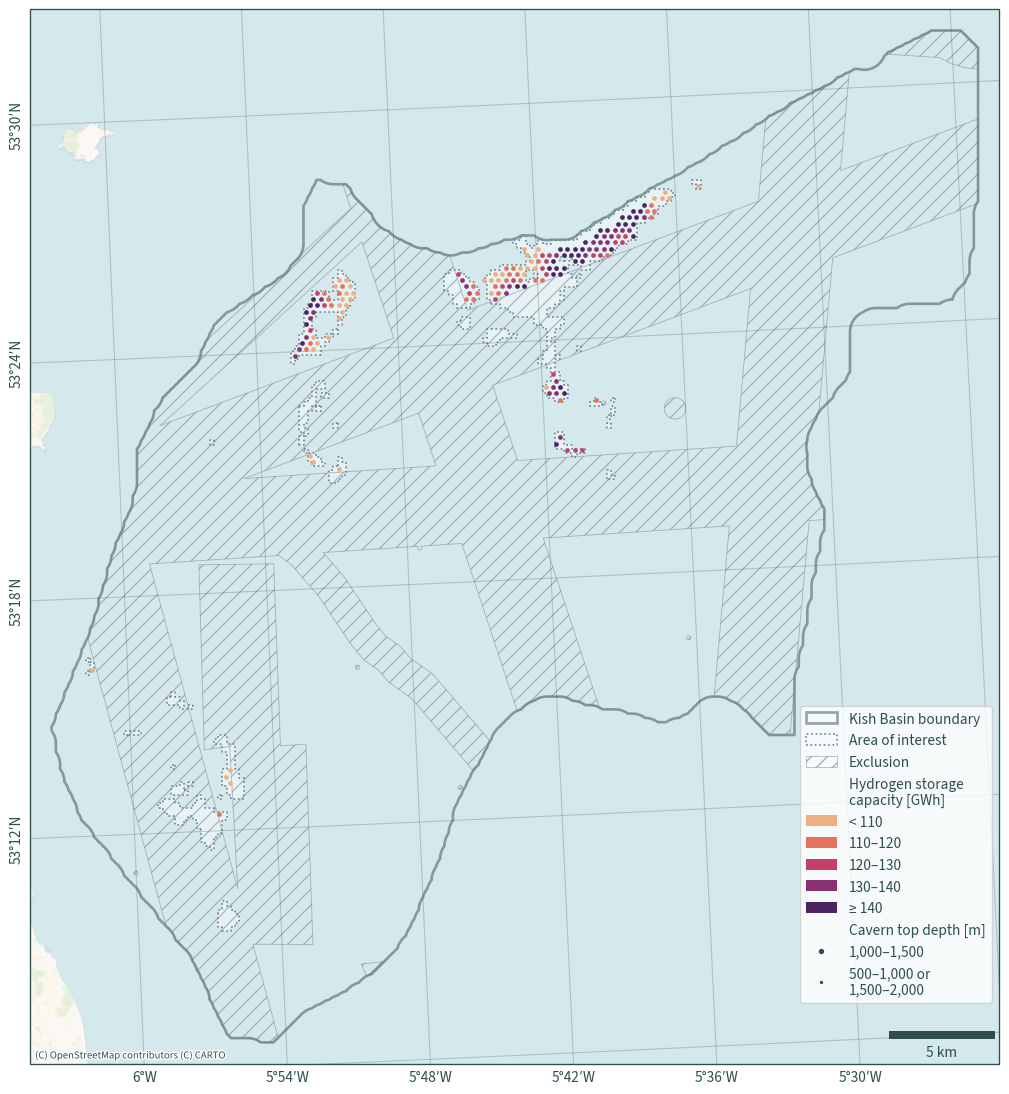

In [167]:
plot_map_alt(ds, caverns, zones, [0, 110, 120, 130, 140])

## Distribution

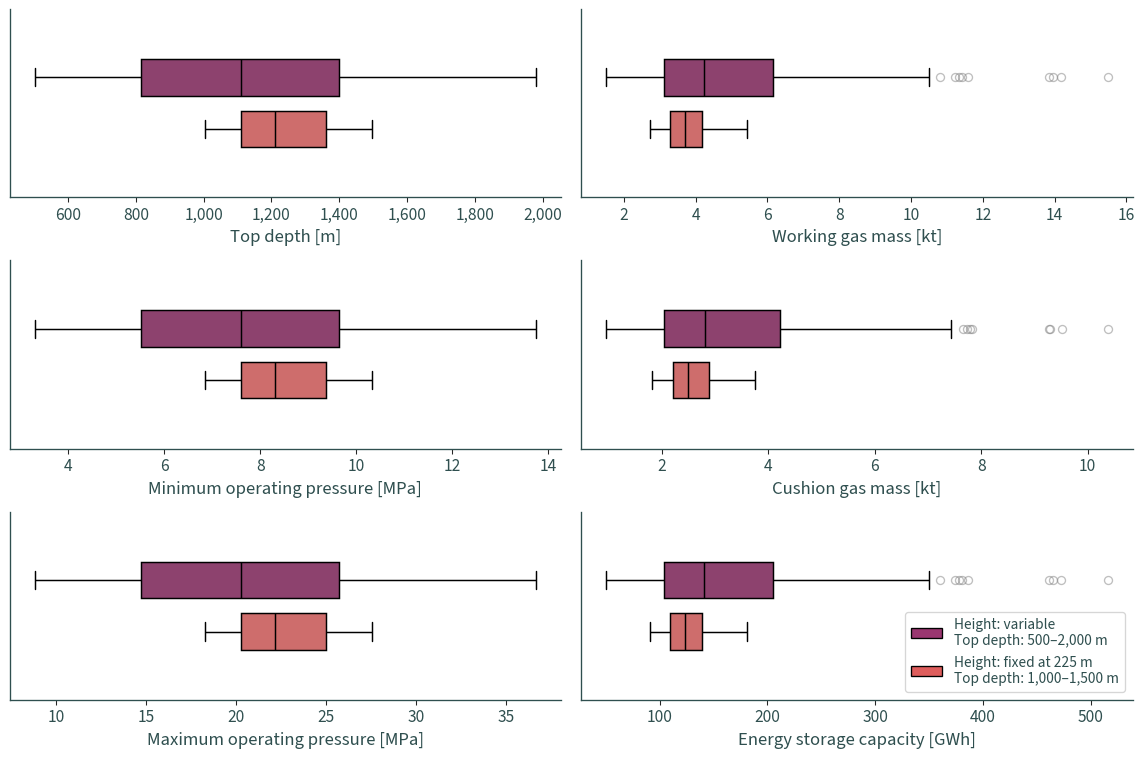

In [170]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for variable, label, axis in zip(
    [
        "cavern_depth",
        "working_mass",
        "p_operating_min",
        "mass_operating_min",
        "p_operating_max",
        "capacity",
    ],
    [
        "Top depth [m]",
        "Working gas mass [kt]",
        "Minimum operating pressure [MPa]",
        "Cushion gas mass [kt]",
        "Maximum operating pressure [MPa]",
        "Energy storage capacity [GWh]",
    ],
    axes.flat,
):
    if variable in ["cavern_depth", "capacity"]:
        d1 = caverns_pot_all[[variable]]
        d2 = caverns[[variable]]
    else:
        d1 = caverns_pot_all[[variable]] / 1e6
        d2 = caverns[[variable]] / 1e6
    sns.boxplot(
        pd.concat(
            [d1.set_axis(["all"], axis=1), d2.set_axis(["optimal"], axis=1)]
        )
        .melt()
        .dropna(),
        x="value",
        hue="variable",
        palette="flare_r",
        linecolor="black",
        linewidth=1.1,
        gap=0.3,
        width=0.55,
        flierprops={"markeredgecolor": "grey", "alpha": 0.5},
        ax=axis,
        legend=False,
    )
    axis.set_xlabel(label)
    axis.tick_params(axis="y", left=False)
    if variable == "cavern_depth":
        axis.get_xaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ","))
        )

legend_handles = [
    mpatches.Patch(
        facecolor=sns.color_palette("flare_r", 2)[0],
        label="Height: variable\nTop depth: 500–2,000 m",
        edgecolor="black",
    ),
    mpatches.Patch(
        facecolor=sns.color_palette("flare_r", 2)[1],
        label="Height: fixed at 225 m\nTop depth: 1,000–1,500 m",
        edgecolor="black",
    ),
]
plt.legend(loc="lower right", handles=legend_handles, fontsize=11.5)
sns.despine()
plt.tight_layout()
plt.show()